# Strapdown Demo

In this notebook we'll walk through how to use the strapdown binary for INS evaluation and GNSS denial and degredation simulation. To start, define some helper functions and ensure that the binary is compiled as a release verion.

In [1]:
!pixi run cargo build --workspace --release

⠁ activating environment                                                        warning: unused variable: `r0`
   --> core/src/messages.rs:863:18
    |
863 |         let (t0, r0) = (&w[0].0, &w[0].1);
    |                  ^^ help: if this is intentional, prefix it with an underscore: `_r0`
    |
    = note: `#[warn(unused_variables)]` on by default

   --> core/src/messages.rs:459:5
    |
447 | struct FaultState {
    |        ---------- field in this struct
...
459 |     ev_u_mps: f64,
    |     ^^^^^^^^
    |
    = note: `FaultState` has derived impls for the traits `Debug` and `Clone`, but these are intentionally ignored during dead code analysis
    = note: `#[warn(dead_code)]` on by default

    Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`release` profile [optimized]]8;;\ target(s) in 0.08s


In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
from haversine import haversine_vector, Unit
from matplotlib import pyplot as plt

ROOT = Path(".").resolve()

def find_strapdown_bin() -> Path:
    if "STRAPDOWN_BIN" in os.environ:
        return Path(os.environ["STRAPDOWN_BIN"])
    exe = "strapdown-sim.exe" if sys.platform.startswith("win") else "strapdown-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError("strapdown-sim not found. Build with `pixi run cargo build --workspace --release`.")


def plot_results(scenario:str):
    """Performance visualization plot helper"""
    truth = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)
    df = pd.read_csv(ROOT.joinpath("out", f'{scenario}.csv'), index_col=0, parse_dates=True)
    truth_coords = truth[["latitude", "longitude", "altitude"]].copy().to_numpy()
    df_coords = df[["latitude", "longitude", "altitude"]].copy().to_numpy()

    two_d_error = haversine_vector(truth_coords[1:, :2], df_coords[1:, :2], Unit.METERS)
    time = (df.index - df.index[0]).total_seconds()
    plt.figure(figsize=(18, 6))
    plt.plot(time[1:], two_d_error)

    plt.xlim(left=0)
    plt.ylim((0, 150))

    plt.xlabel('Time (s)')
    plt.ylabel('Haversine Error (m)')
    plt.title('Simulation Results')
    #plt.legend()
    plt.grid()
    plt.show()

Next we'll setup the output directory for saving off results.

In [3]:
ROOT.joinpath("out").mkdir(exist_ok=True)

## Truth

First we'll develop a baseline scenario with no GNSS degradation. This will serve as the "truth" scenario against which we can compare the degraded scenarios. Due to shell and environment variable management, we'll instead invoke the simulation from Python using subprocess.run(..) instead of relying on the shell directly (ie !strapdown-sim ...)

In [4]:
from subprocess import run

In [5]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/baseline.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "none",
  "--seed", "42"], check=False)

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/baseline.csv


CompletedProcess(args=[PosixPath('/home/james/Code/strapdown-rs/target/release/strapdown-sim'), '-i', PosixPath('/home/james/Code/strapdown-rs/sim/data/test_data.csv'), '-o', 'out/baseline.csv', 'closed-loop', '--sched', 'passthrough', '--fault', 'none', '--seed', '42'], returncode=0)

## Individual fault models

This section runs a test case example for each type of built in fault model.

### Degraded (AR(1)) @ full GNSS rate

Expect: smooth horizontal wander (few meters), velocity slightly noisy; innovations/NIS stay reasonable because R is inflated by r_scale.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/degraded_fullrate.csv


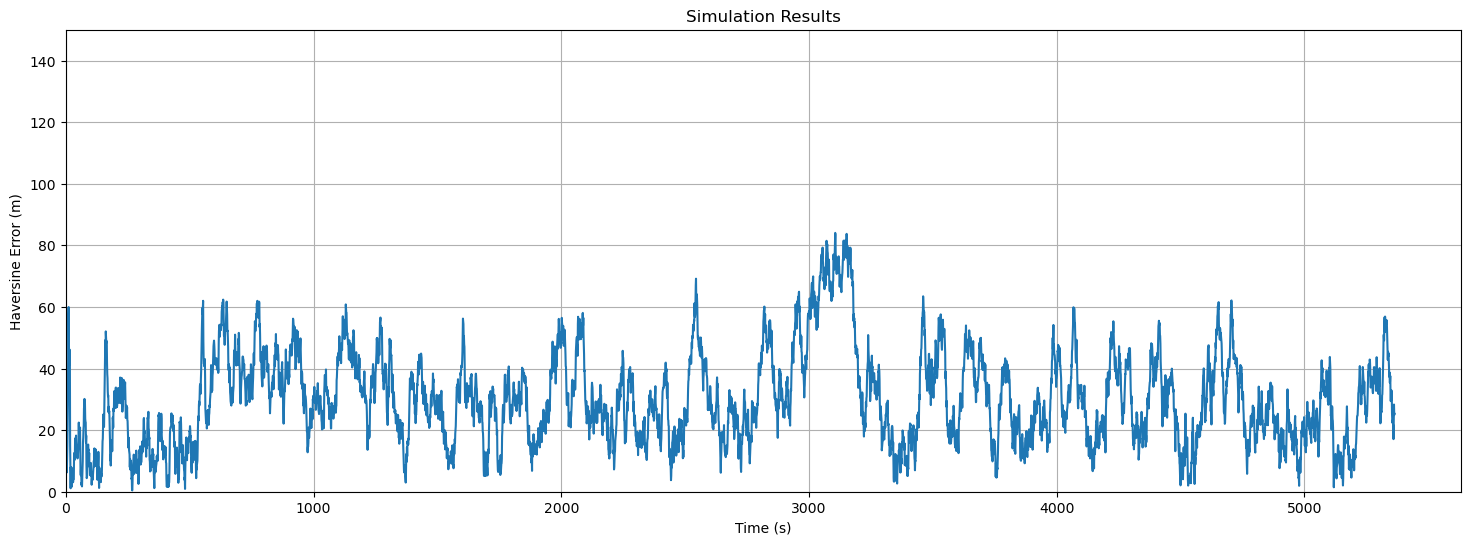

In [6]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/degraded_fullrate.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "3", "--rho-vel", "0.95", "--sigma-vel-mps", "0.3", "--r-scale", "5",
  "--seed", "42"
])
plot_results("degraded_fullrate")

### Degraded (AR(1)) + reduced GNSS
Expect: “sawtooth” position error between fixes; RMS often 10–30 m depending on motion.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/degraded.csv


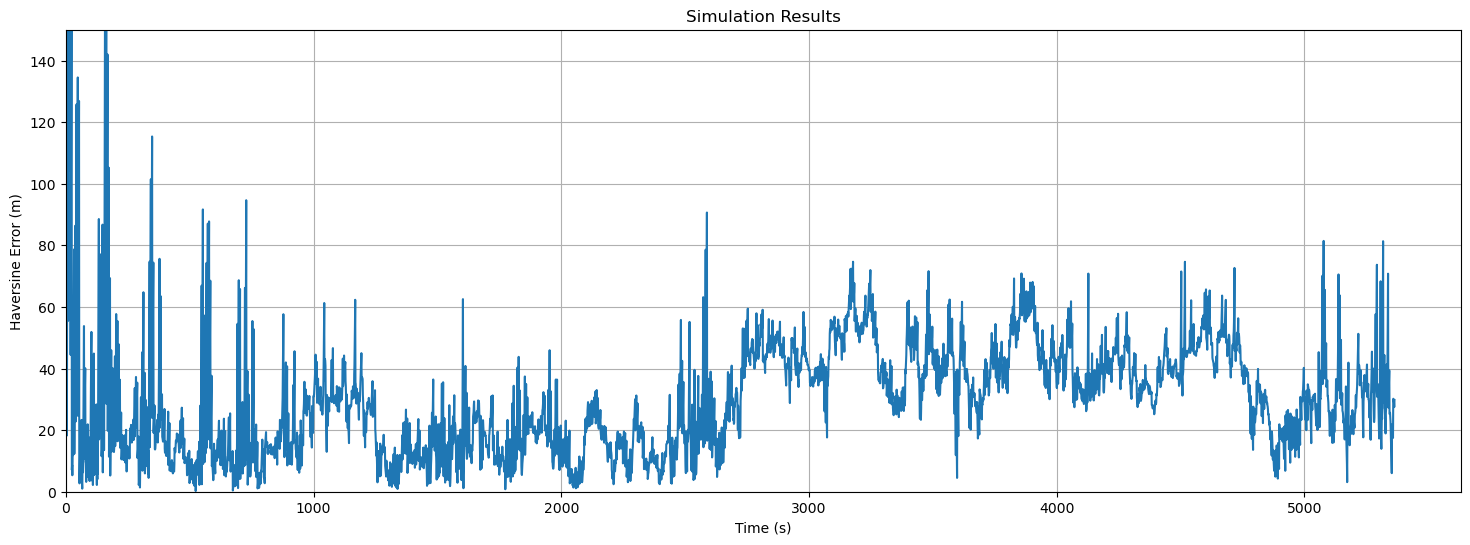

In [7]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/degraded.csv", "closed-loop",
  "--sched", "fixed", "--interval-s", "5",
  "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "3", "--rho-vel", "0.95", "--sigma-vel-mps", "0.3", "--r-scale", "5",
  "--seed", "42"
])
  
plot_results("degraded")

### SlowBias (soft spoof) @ 1 Hz GNSS

Expect: steady north drift (~2 cm/s); lat/lon error grows roughly linearly with time; velocities biased by (0.02, 0.0) m/s.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/slowbias.csv


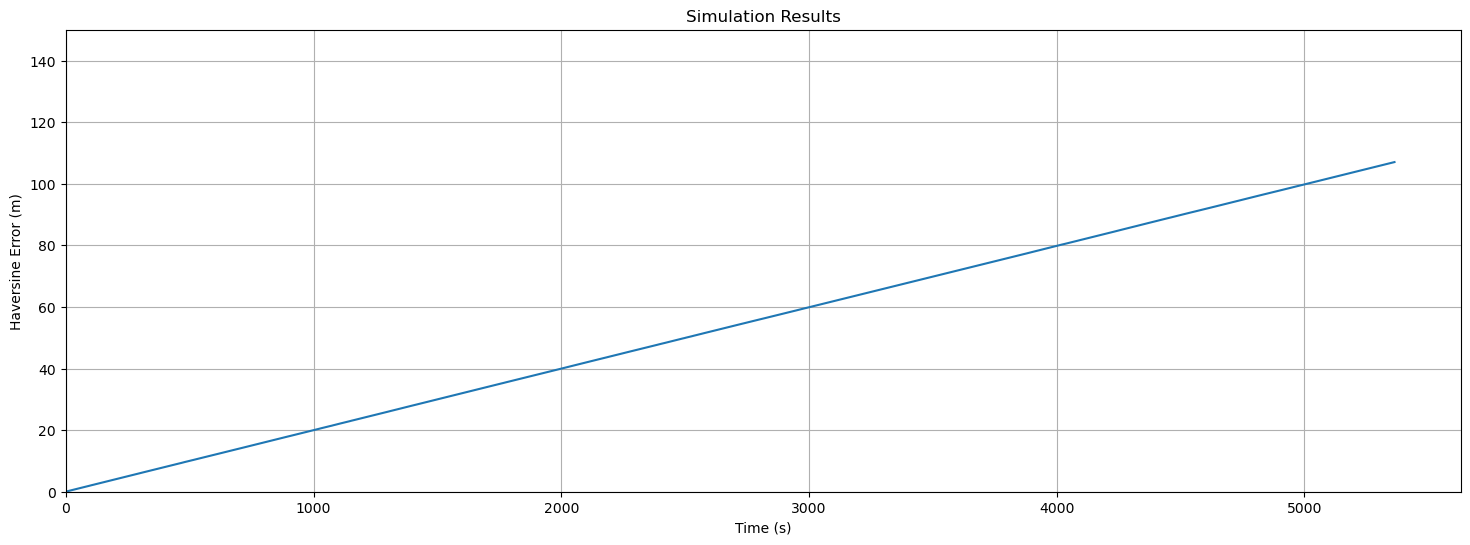

In [8]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/slowbias.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "slowbias", "--drift-n-mps", "0.02", "--drift-e-mps", "0.00", "--q-bias", "1e-6", "--rotate-omega-rps", "0.0",
  "--seed", "42"
])

#!target/release/strapdown  -i core/data/test_data.csv -o out/slowbias.csv closed-loop\
#  --sched passthrough \
#  --fault slowbias --drift-n-mps 0.02 --drift-e-mps 0.00 --q-bias 1e-6 --rotate-omega-rps 0.0 \
#  --seed 42

plot_results("slowbias")

### SlowBias with slow rotation (soft curved spoof)

Expect: drift direction slowly rotates (~0.057°/s); lateral error forms an arc.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/slowbias_rot.csv


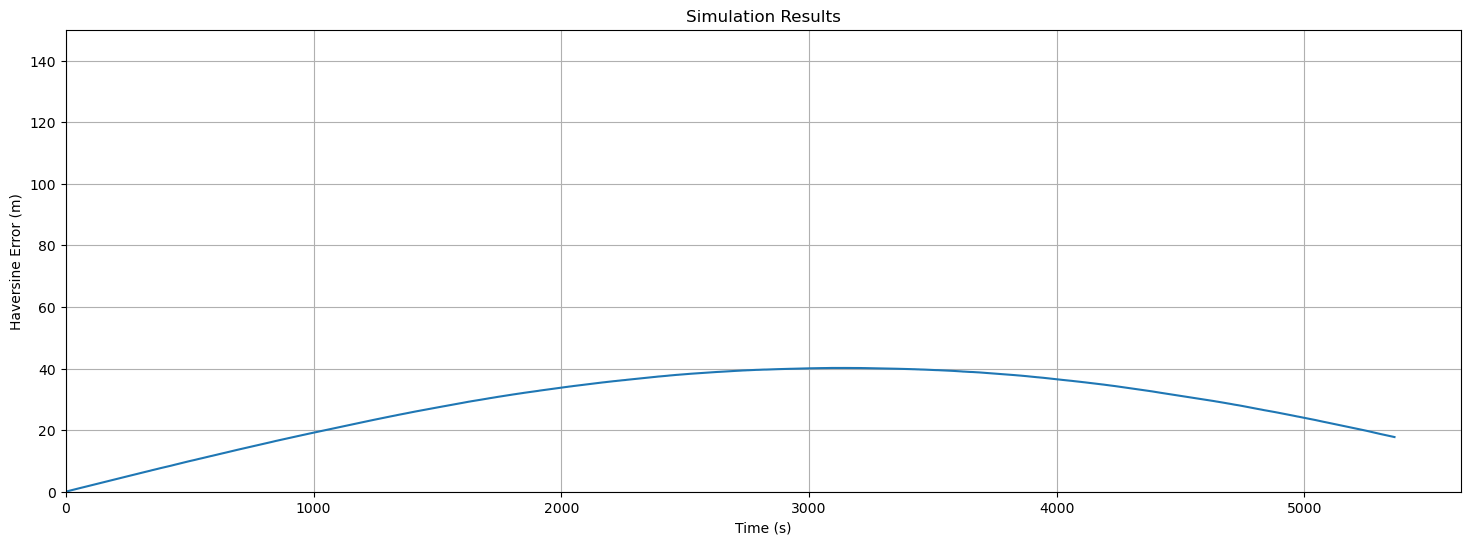

In [9]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/slowbias_rot.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "slowbias", "--drift-n-mps", "0.02", "--drift-e-mps", "0.00", "--q-bias", "5e-6", "--rotate-omega-rps", "1e-3",
  "--seed", "42"
])

# !target/release/strapdown -i core/data/test_data.csv -o out/slowbias_rot.csv closed-loop\
#   --sched passthrough \
#   --fault slowbias --drift-n-mps 0.02 --drift-e-mps 0.00 --q-bias 5e-7 --rotate-omega-rps 1e-3 \
#   --seed 42

plot_results("slowbias_rot")

### Hijack (hard offset) 

A spoofing attack occurs for a 60 second window starting at t=120 seconds

Expect: abrupt ~50 m north offset only inside [120, 180] s; returns to nominal after.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/hijack.csv


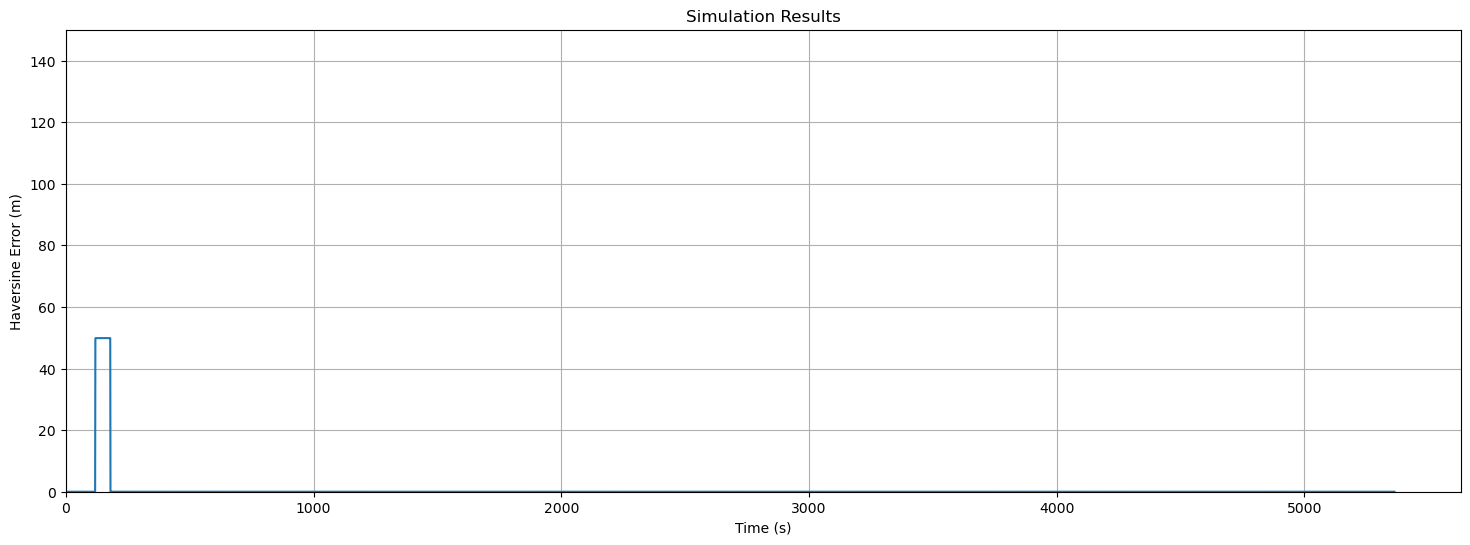

In [10]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/hijack.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "hijack", "--hijack-start-s", "120", "--hijack-duration-s", "60", "--hijack-offset-n-m", "50", "--hijack-offset-e-m", "0",
  "--seed", "42"
])

# !target/release/strapdown -i core/data/test_data.csv -o out/hijack.csv closed-loop \
#   --sched passthrough \
#   --fault hijack --hijack-start-s 120 --hijack-duration-s 60 --hijack-offset-n-m 50 --hijack-offset-e-m 0 \
#   --seed 42

plot_results("hijack")

## Scheduler-only effects 

These fault conditions only concern the *availability* of GNSS signals. The signal itself is not corrupted just intermittently or periodically unavailable or provided at a much reduced rate.

### Reduced rate only, no fault

Expect: INS drift between fixes; error clamps at each 10 s update.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.94%...Done!
Results written to out/sched.csv


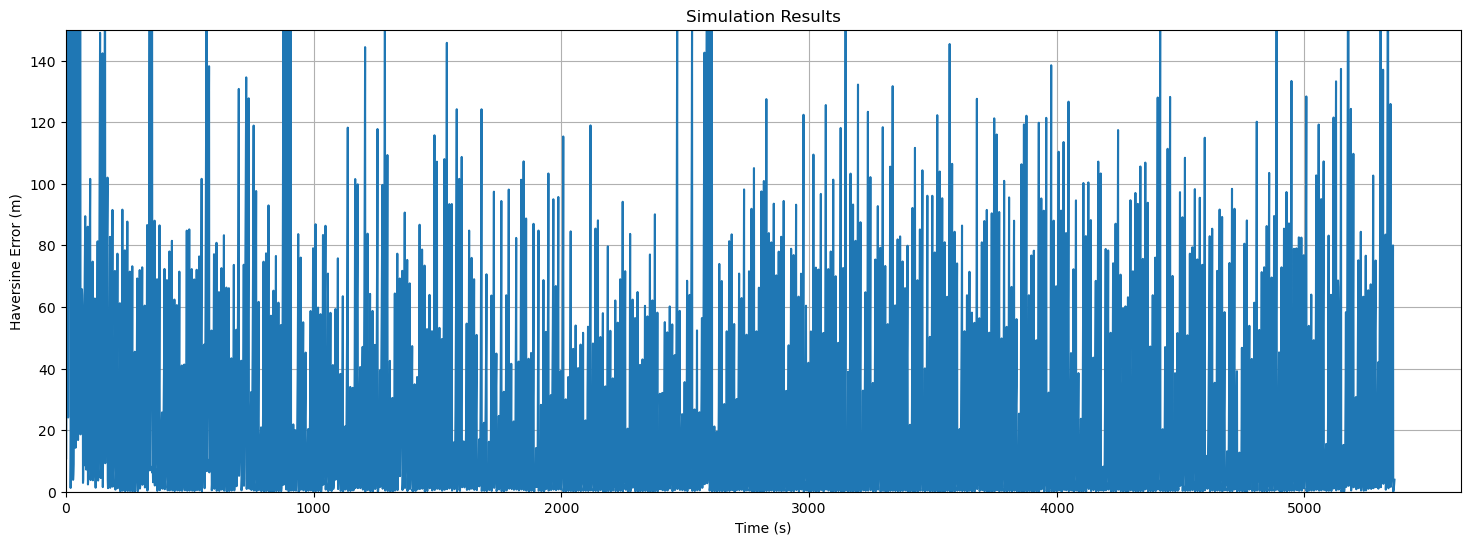

In [11]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/sched.csv", "closed-loop",
  "--sched", "fixed", "--interval-s", "10",
  "--fault", "none",
  "--seed", "42"
])

# !target/release/strapdown -i core/data/test_data.csv -o out/sched_10s.csv closed-loop \
#   --sched fixed --interval-s 10 \
#   --fault none \
#   --seed 42

plot_results("sched")

### Duty-cycle outages (10 s ON / 20 s OFF)

Expect: growing error during OFF windows; recovery during ON; repeat.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.94%...Done!
Results written to out/duty.csv


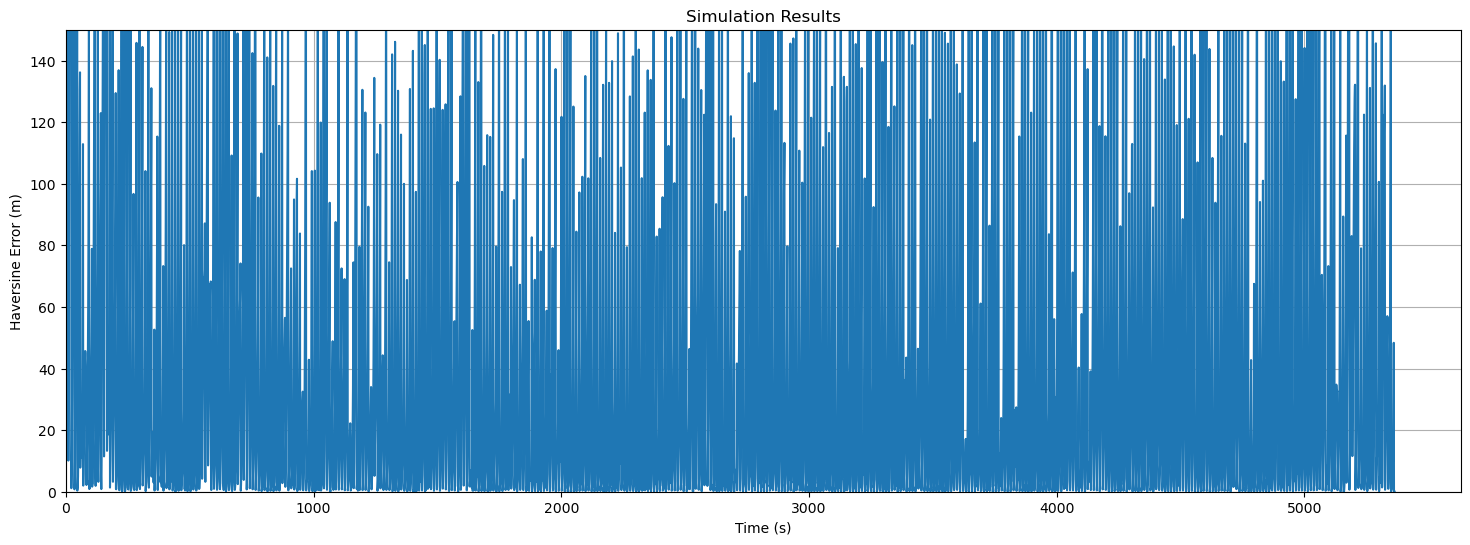

In [12]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/duty.csv", "closed-loop",
  "--sched", "duty", "--on-s", "10", "--off-s", "2", "--duty-phase-s", "1",
  "--fault", "none",
  "--seed", "42"
])

# !target/release/strapdown -i core/data/test_data.csv -o out/duty_10on_5off.csv closed-loop \
#   --sched duty --on-s 10 --off-s 20 --duty-phase-s 1 \
#   --fault none \
#   --seed 42

plot_results("duty")

## Combination Scenarios

Degraded + SlowBias (soft spoof under poor SNR) + 10 s rate

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/combo.csv


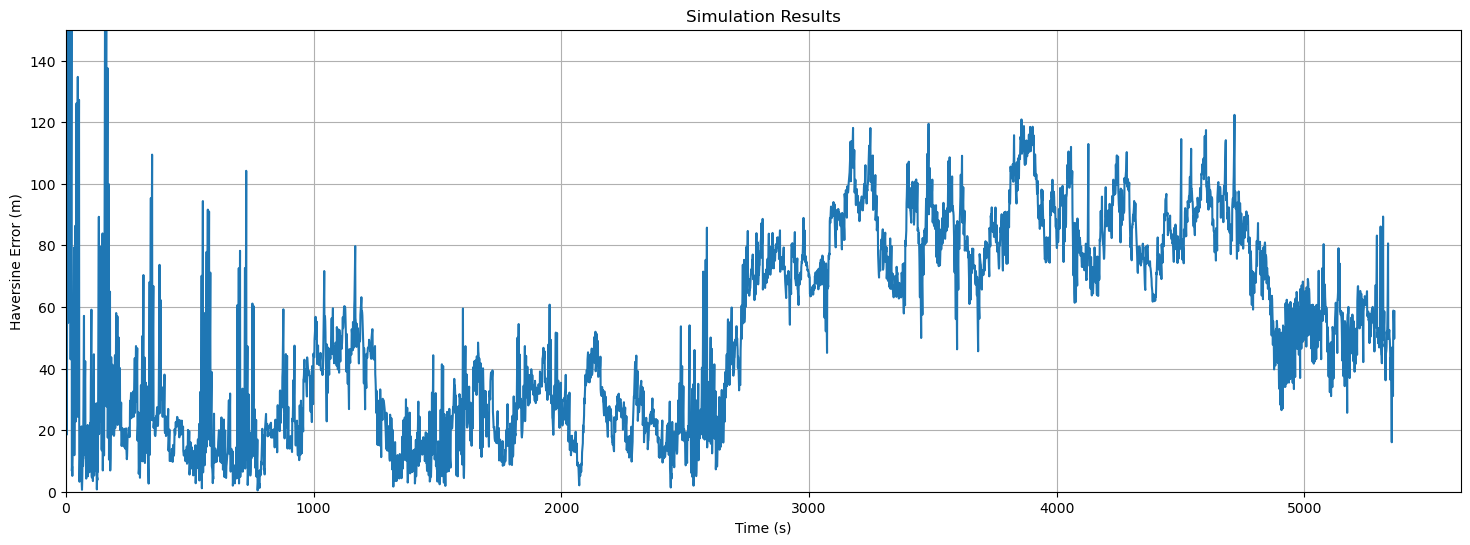

In [13]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/combo.csv", "closed-loop",
  "--sched", "fixed", "--interval-s", "5",
  "--fault", "degraded", "--rho-pos", "0.995", "--sigma-pos-m", "4", "--rho-vel", "0.97", "--sigma-vel-mps", "0.35", "--r-scale", "5",
  "--seed", "42"
])

# !target/release/strapdown -i core/data/test_data.csv -o out/combo_deg_slowbias_5s.csv closed-loop\
#   --sched fixed --interval-s 5 \
#   --fault degraded --rho-pos 0.995 --sigma-pos-m 4 --rho-vel 0.97 --sigma-vel-mps 0.35 --r-scale 5 \
#   --seed 42

plot_results("combo")

### Duty-cycle outages + Hijack window (stress)

Expect: large jumps inside hijack window, plus drift during OFF periods.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.98%...Done!
Results written to out/combo_duty_hijack.csv


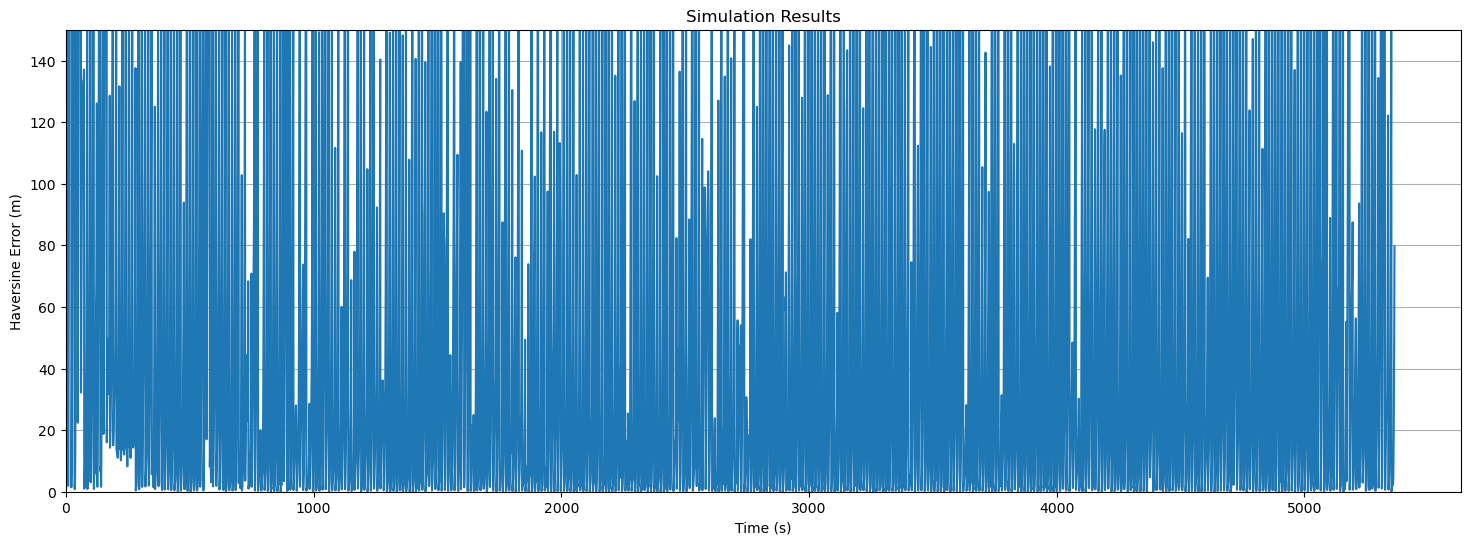

In [14]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/combo_duty_hijack.csv", "closed-loop",
  "--sched", "duty", "--on-s", "10", "--off-s", "3", "--duty-phase-s", "0",
  "--fault", "hijack", "--hijack-start-s", "150", "--hijack-duration-s", "120", "--hijack-offset-n-m", "10", "--hijack-offset-e-m", "10",
  "--seed", "42"
])

# !target/release/strapdown -i core/data/test_data.csv -o out/combo_duty_hijack.csv closed-loop\
#   --sched duty --on-s 8 --off-s 22 --duty-phase-s 0 \
#   --fault hijack --hijack-start-s 150 --hijack-duration-s 45 --hijack-offset-n-m 60 --hijack-offset-e-m 20 \
#   --seed 42

plot_results("combo_duty_hijack")
